In [1]:
import datetime as dt
import itertools
from pathlib import Path

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import seaborn as sns
import xarray as xr

from remake import load_remake

from mcs_prime import McsTracks, PATHS
from mcs_prime.util import update_progress
%matplotlib inline

In [2]:
mle = load_remake('../../remakefiles/mcs_local_envs.py')

loading pixel inputs cache


In [3]:
t = mle.LifecycleMcsLocalEnvHist.tasks[0]

In [4]:
ds = xr.open_dataset(t.outputs['lifecycle_mcs_local_env'])

In [5]:
ds.hist_cape.load()
ds.hist_tcwv.load()
ds.mean_cape.load()
ds.mean_tcwv.load();

In [6]:
def plot_precursor_dists(ds, var, radius=500):
    palette = sns.color_palette('viridis', 24)
    hist = ds[f'hist_{var}'].sel(radius=radius).isel(times=slice(0, 24)).mean(dim='tracks').values

    # plot_data = ds[var].sel(radius=radius, times=slice(0, 23)).mean(dim='tracks').values
    fig = plt.figure(figsize=(20, 7))
    for c, i in zip(palette, range(hist.shape[1])):
        plt.plot(ds[f'{var}_hist_mids'].values, hist[:, i] / hist[:, i].sum(), color=c, label=i - 24)
    if var ==  'cape':
        if True:
            plt.gca().set_yscale('log')
            plt.ylim((1e-3, None))
        else:
            
            if radius == 100:
                plt.ylim((0, 3))
            elif radius == 200:
                plt.ylim((0, 12))
            elif radius == 500:
                plt.ylim((0, 60))
            elif radius == 1000:
                plt.ylim((0, 240))

    if var == 'cape':
        plt.xlim((0, 2000))
    plt.legend()

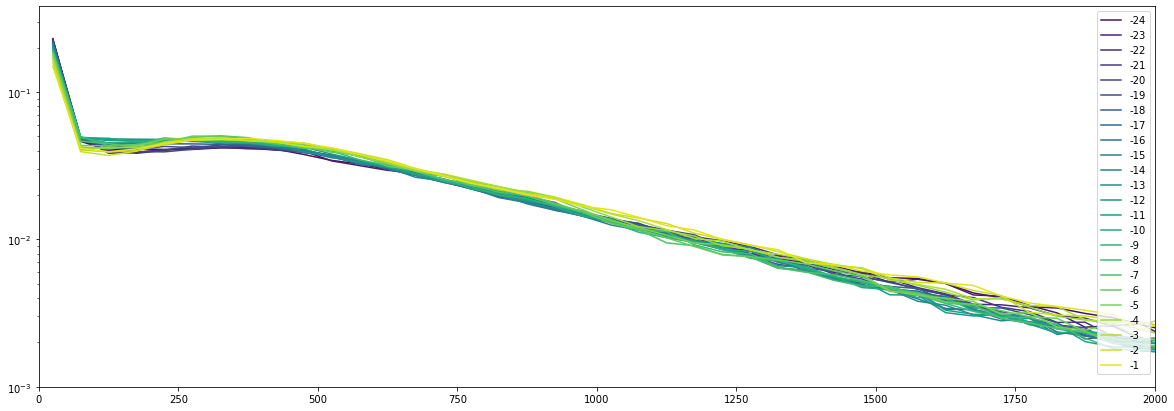

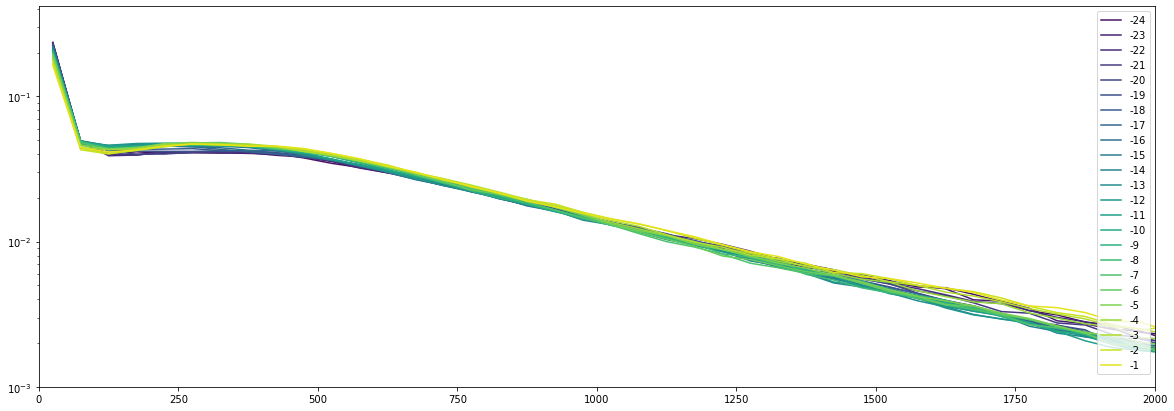

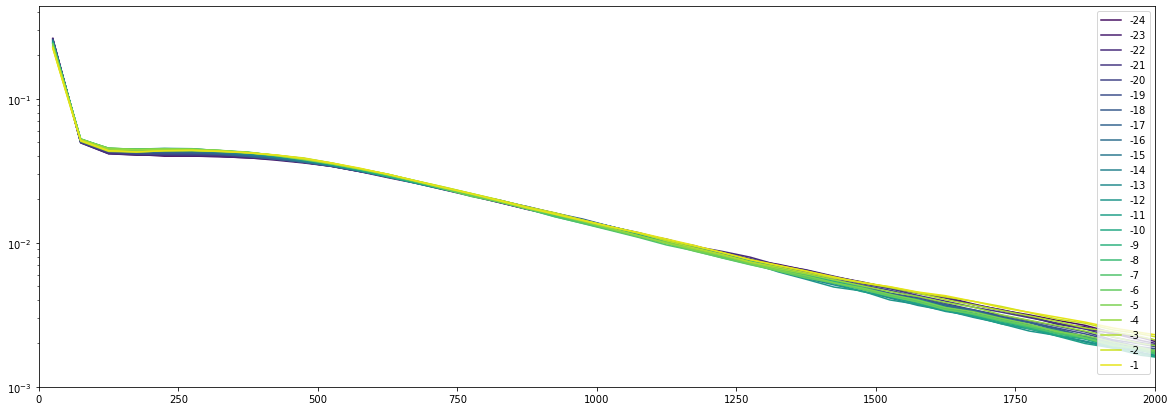

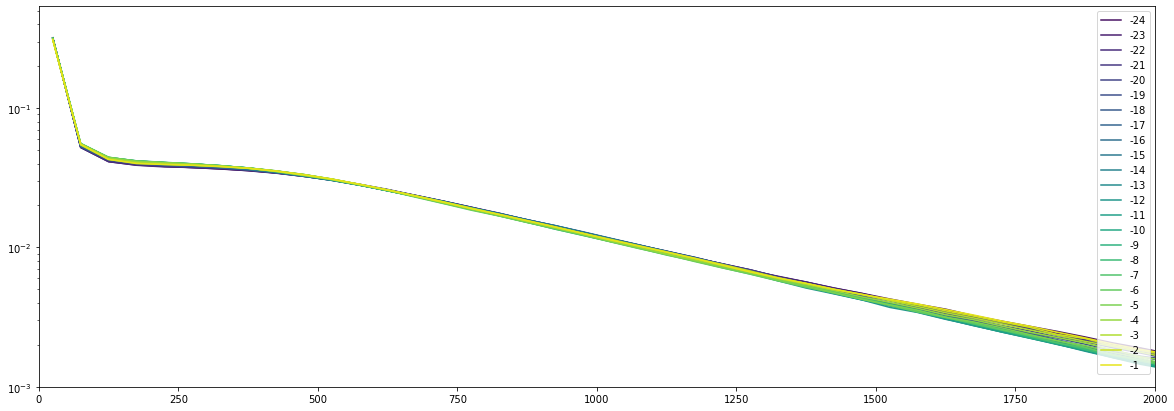

In [7]:
for r in [100, 200, 500, 1000]:
    plot_precursor_dists(ds, 'cape', r)


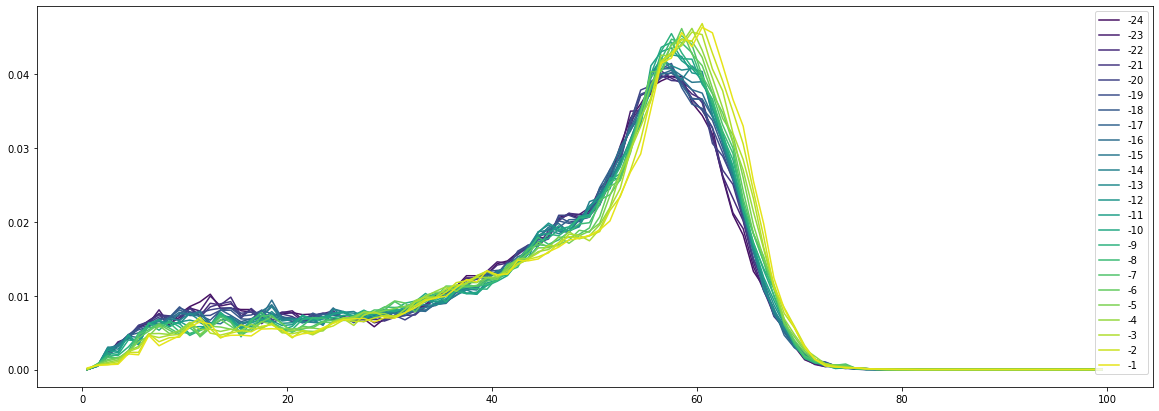

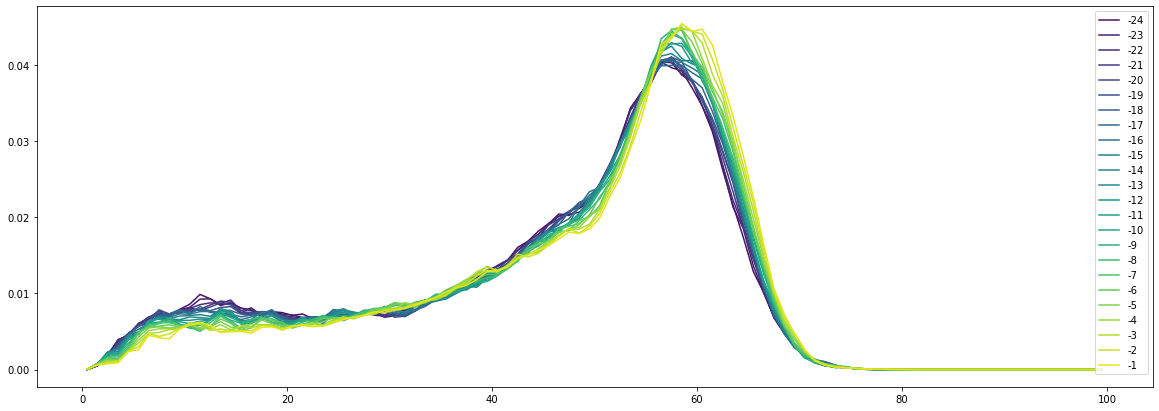

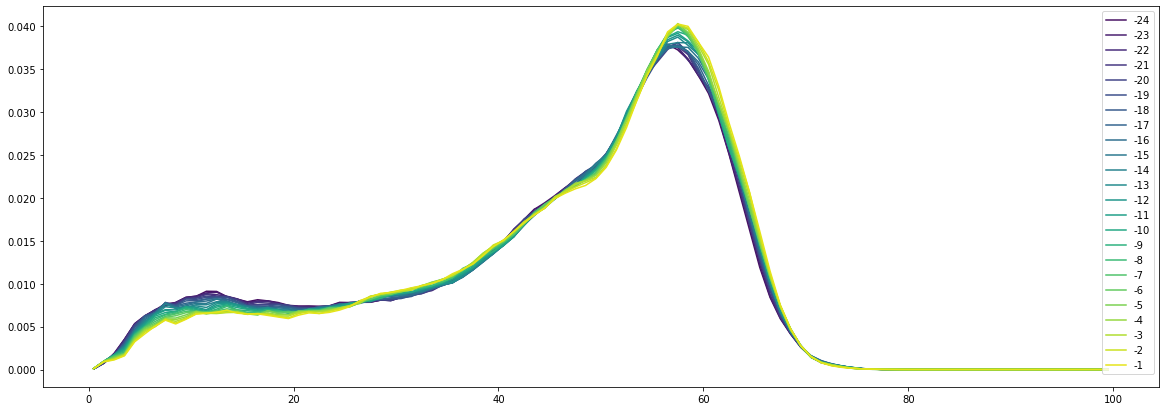

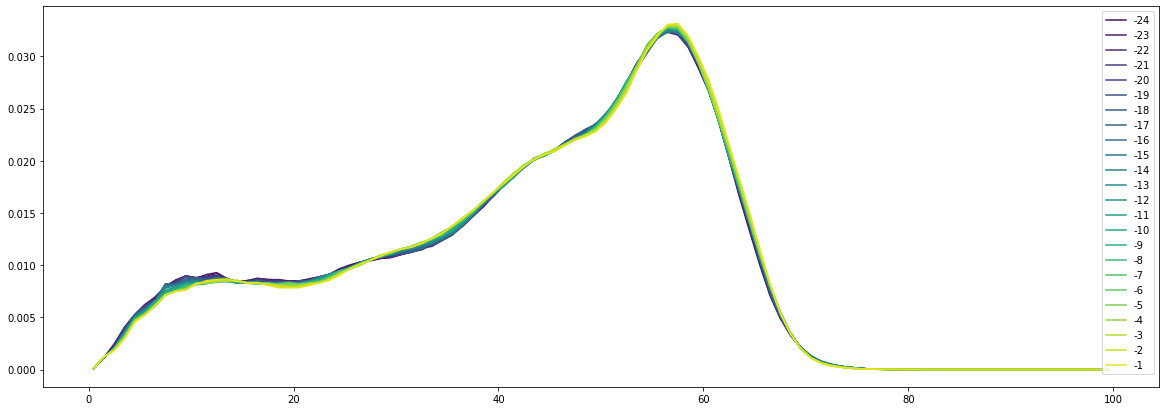

In [8]:
for r in [100, 200, 500, 1000]:
    plot_precursor_dists(ds, 'tcwv', r)

In [9]:
def plot_precursor_mean_val(ds, var, N=60):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches((20, 8))
    for r in [100, 200, 500, 1000]:
        data = ds[f'mean_{var}'].sel(radius=r).isel(times=slice(0, N)).mean(dim='tracks')
        ax1.plot(range(-24, -24 + N), data, label=r)
        
    hist_data = ds[f'hist_{var}'].sel(radius=100).isel(times=slice(0, N))
    ax2.plot(range(-24, -24 + N), np.isnan(hist_data.values).sum(axis=(0, 1)))
    ax1.legend()
    for ax in [ax1, ax2]:
        ax.axvline(x=0)

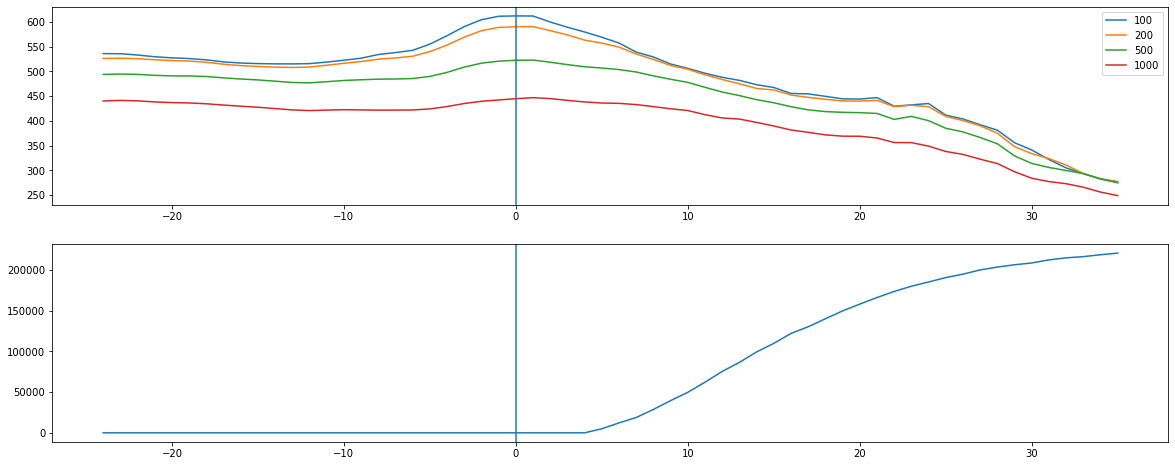

In [10]:
plot_precursor_mean_val(ds, 'cape')

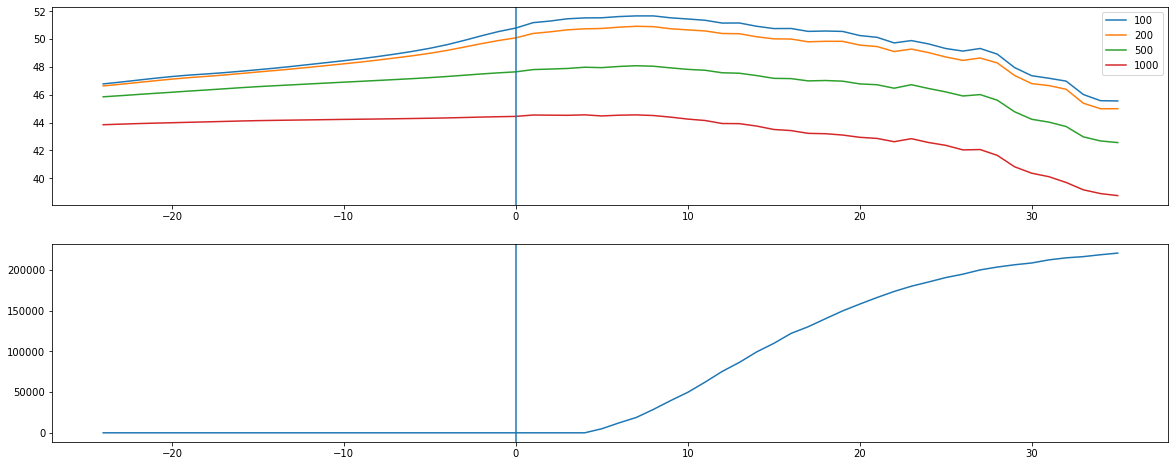

In [11]:
plot_precursor_mean_val(ds, 'tcwv')

In [12]:
# Edit these based on where these are on your system.
statsdir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats')

In [13]:
stats_paths = sorted(statsdir.glob('mcs_tracks_final_extc_????????.0000_????????.0000.nc'))
print(stats_paths[0])
print(stats_paths[-1])

/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20000601.0000_20010101.0000.nc
/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20200101.0000_20210101.0000.nc


In [14]:
tracks = McsTracks.open(stats_paths[-1])

In [15]:
tracks

McsTracks[2020-01-01 00:30:00, 2020-12-31 22:30:00, ntracks=32138]

In [16]:
mcs_start_times = pd.DatetimeIndex(tracks.dstracks.start_basetime.values)

In [18]:
dstracks_jan = tracks.dstracks.isel(tracks=(mcs_start_times.month == 1))

In [20]:
dstracks_jan

<xarray.Dataset>
Dimensions:                  (tracks: 2406, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 2402 2403 2404 2405
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] 2020-01-01T00:30:00 ... ...
    end_basetime             (tracks) datetime64[ns] 2020-01-01T11:30:00 ... ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 03:42:36 2022
    startdate:                   20200101.0000
    enddate:                     20210101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [21]:
ds

<xarray.Dataset>
Dimensions:          (tracks: 2406, radius: 5, cape_hist_mids: 100, times: 424,
                      percentile: 5, tcwv_hist_mids: 100, cape_bins: 101,
                      tcwv_bins: 101)
Coordinates:
  * tracks           (tracks) int64 0 1 2 3 4 5 ... 2401 2402 2403 2404 2405
  * radius           (radius) int64 1 100 200 500 1000
  * times            (times) int64 -24 -23 -22 -21 -20 ... 395 396 397 398 399
  * percentile       (percentile) int64 10 25 50 75 90
  * cape_hist_mids   (cape_hist_mids) float64 25.0 75.0 ... 4.925e+03 4.975e+03
  * cape_bins        (cape_bins) float64 0.0 50.0 100.0 ... 4.95e+03 5e+03
  * tcwv_hist_mids   (tcwv_hist_mids) float64 0.5 1.5 2.5 3.5 ... 97.5 98.5 99.5
  * tcwv_bins        (tcwv_bins) float64 0.0 1.0 2.0 3.0 ... 98.0 99.0 100.0
Data variables:
    hist_cape        (tracks, radius, cape_hist_mids, times) float64 1.0 ... nan
    mean_cape        (tracks, radius, times) float64 0.0 0.0 2.729 ... nan nan
    percentile_cape  (tracks, radius, percentile, times) float64 ...
    hist_tcwv        (tracks, radius, tcwv_hist_mids, times) float64 0.0 ... nan
    mean_tcwv        (tracks, radius, times) float64 38.35 39.23 ... nan nan
    percentile_tcwv  (tracks, radius, percentile, times) float64 ...

In [22]:
max_areas = np.nanmax(dstracks_jan.area.values, axis=1)


In [23]:
max_area_thresh = np.percentile(max_areas, [25, 50, 75])


In [25]:
max_area_thresh
max_area_bins = np.array([0] + list(max_area_thresh) + [1e7])

In [72]:
def gen_mask(field, bins):
    mask = np.zeros((len(ds.tracks), len(bins) - 1), dtype=bool)
    for i in range(len(bins) - 1):
        mask[:, i] = ((field > bins[i]) & (field <= bins[i + 1]))
    return mask

In [53]:
max_area_mask = gen_mask(max_areas, max_area_bins)

In [54]:
max_area_masks.sum(axis=0)

array([601, 599, 599, 602])

In [69]:
def plot_precursor_mean_val_with_mask(ds, var, mask, bins, r=200, N=60):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches((20, 8))
    data = ds[f'mean_{var}'].sel(radius=r).isel(times=slice(0, N))
    for i in range(mask.shape[1]):
        print(i)
        plot_data = data.isel(tracks=mask[:, i]).mean(dim='tracks')
        label = f'{bins[i]} - {bins[i + 1]}'
        ax1.plot(range(-24, -24 + N), plot_data, label=label)
    ax1.legend()
        
    for ax in [ax1]:
        ax.axvline(x=0)

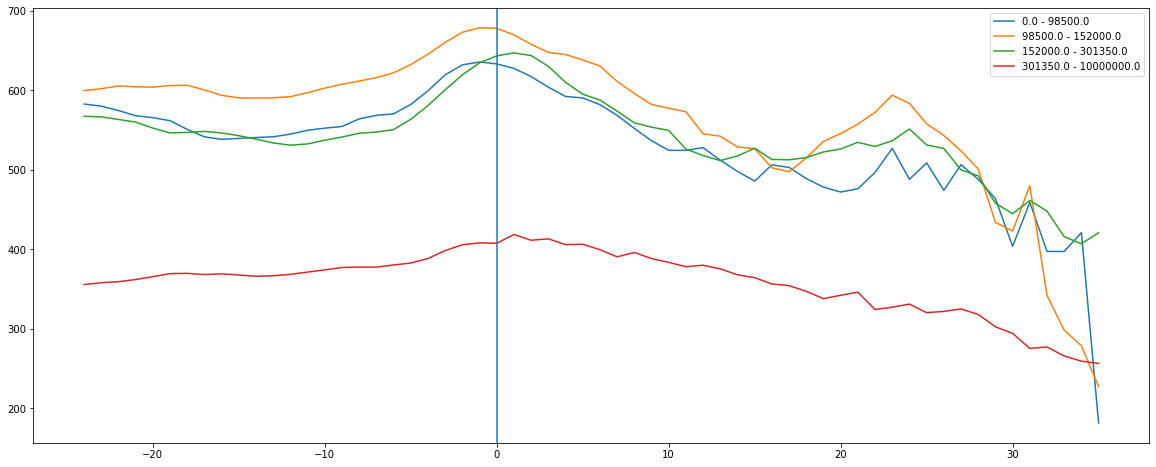

In [56]:
plot_precursor_mean_val_with_mask(ds, 'cape', max_area_masks, max_area_bins)

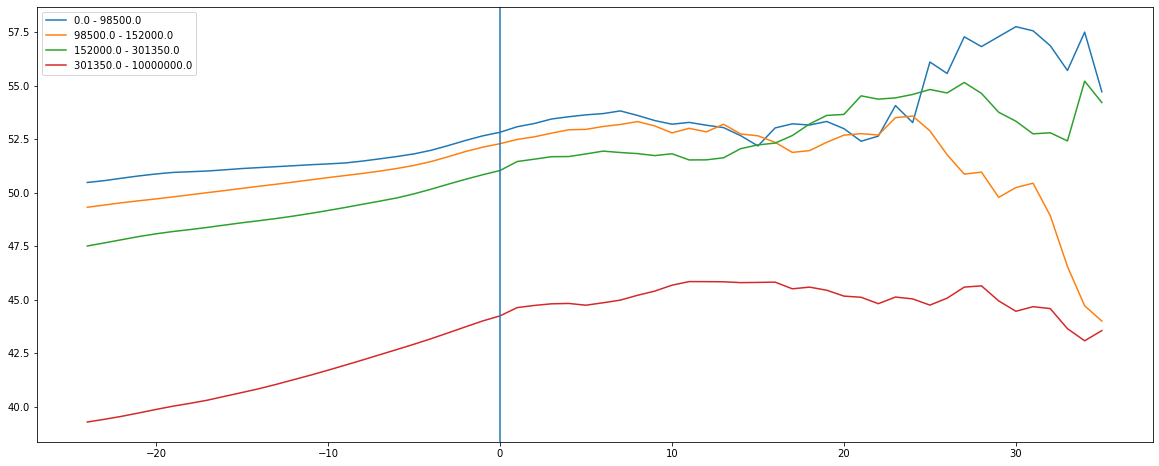

In [57]:
plot_precursor_mean_val_with_mask(ds, 'tcwv', max_area_masks, max_area_bins)

In [58]:
meanlats = np.nanmean(dstracks_jan.meanlat.values, axis=1)

In [61]:
lat_bins = [-61, -40, -20, 20, 40, 60]
lat_mask = gen_mask(meanlats, lat_bins)

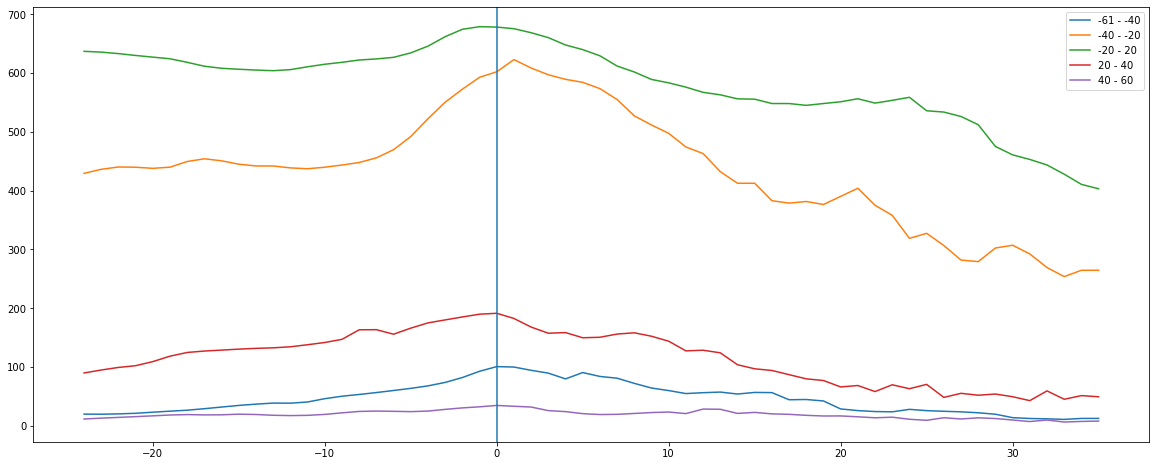

In [63]:
plot_precursor_mean_val_with_mask(ds, 'cape', lat_mask, lat_bins)

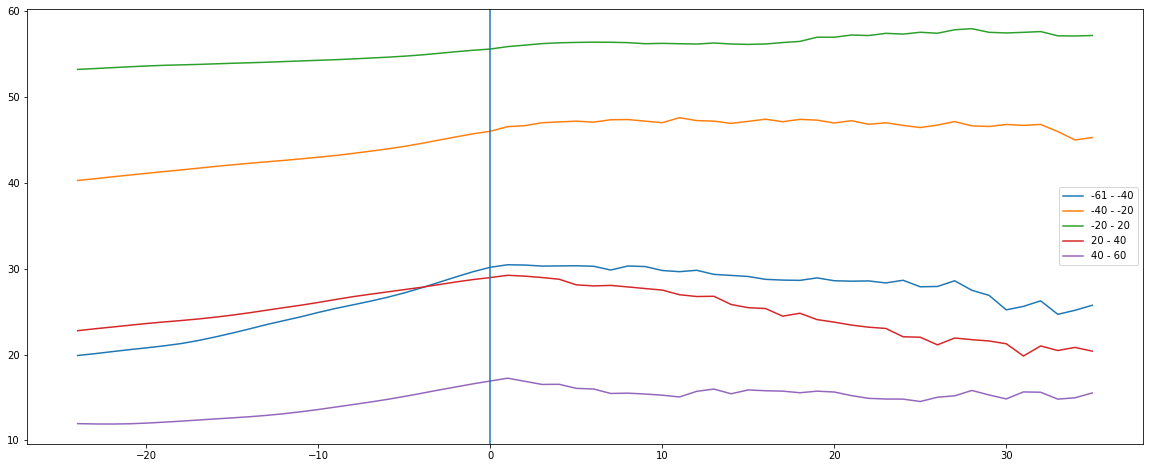

In [64]:
plot_precursor_mean_val_with_mask(ds, 'tcwv', lat_mask, lat_bins)

In [73]:
durations = dstracks_jan.track_duration.values
duration_bins = [0, 12, 24, 400]
duration_mask = gen_mask(durations, duration_bins)

0
1
2


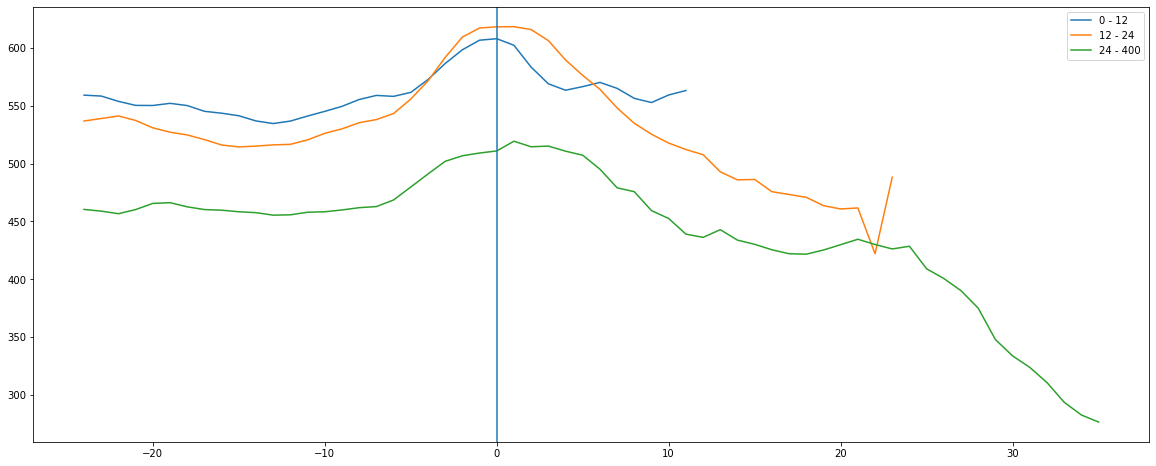

In [74]:
plot_precursor_mean_val_with_mask(ds, 'cape', duration_mask, duration_bins)